Epoch 000: Loss: 2.622, Accuracy: 17.451%
Epoch 002: Loss: 1.885, Accuracy: 47.647%
Epoch 004: Loss: 1.470, Accuracy: 69.216%
Epoch 006: Loss: 1.187, Accuracy: 80.392%
Epoch 008: Loss: 0.977, Accuracy: 88.824%
Epoch 010: Loss: 0.823, Accuracy: 93.922%
Epoch 012: Loss: 0.700, Accuracy: 94.510%
Epoch 014: Loss: 0.605, Accuracy: 96.275%
Epoch 016: Loss: 0.529, Accuracy: 97.647%
Epoch 018: Loss: 0.466, Accuracy: 97.843%
Epoch 020: Loss: 0.417, Accuracy: 98.235%
Epoch 022: Loss: 0.375, Accuracy: 98.627%
Epoch 024: Loss: 0.338, Accuracy: 99.020%
Epoch 026: Loss: 0.308, Accuracy: 99.216%
Epoch 028: Loss: 0.281, Accuracy: 99.412%
Epoch 030: Loss: 0.258, Accuracy: 99.412%
Epoch 032: Loss: 0.239, Accuracy: 99.804%
Epoch 034: Loss: 0.222, Accuracy: 99.804%
Epoch 036: Loss: 0.206, Accuracy: 100.000%
Epoch 038: Loss: 0.192, Accuracy: 100.000%
Epoch 040: Loss: 0.180, Accuracy: 100.000%
Epoch 042: Loss: 0.169, Accuracy: 100.000%
Epoch 044: Loss: 0.159, Accuracy: 100.000%
Epoch 046: Loss: 0.151, Accur

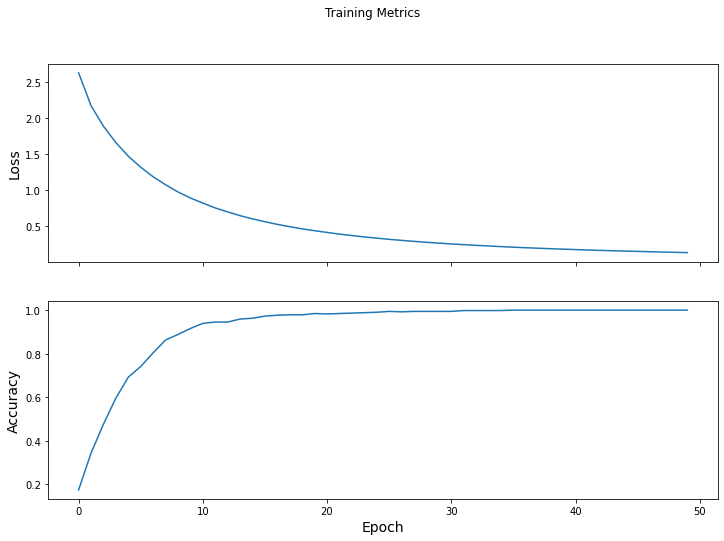

Test set accuracy: 87.500%


In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

LABEL_COLUMN = 'letter'
LABELS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def get_dataset(file_path, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=10, # Artificially small to make examples easier to show.
      label_name=LABEL_COLUMN,
      na_value="?",
      num_epochs=1,
      shuffle=True,
      ignore_errors=True, 
      **kwargs)
  return dataset

train_dataset = get_dataset('C:\\Users\\Tomi\\Desktop\\jupyter\\trainset.csv')



def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels




train_dataset = train_dataset.map(pack_features_vector)
features, labels = next(iter(train_dataset))

model = tf.keras.Sequential([
  tf.keras.layers.Dense(170, activation=tf.nn.relu, input_shape=(2500,)),  # input shape required
  tf.keras.layers.Dense(10)
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)





def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)




## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 50

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 2 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))


#Visualize the loss function over time  ; you really want to see the loss go down and the accuracy go up
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()


#model.save("my_model")         To save model


################################################################## To test the model

def get_testset(file_path, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size = 10,
      label_name= "predict",
      na_value="?",
      num_epochs=1,
      shuffle=False, 
      **kwargs)
  return dataset


  

test_dataset = get_testset('C:\\Users\\Tomi\\Desktop\\jupyter\\testset.csv')
test_dataset = test_dataset.map(pack_features_vector)


test_accuracy = tf.keras.metrics.Accuracy()
model_predicts = []
dataset_labels = []
for (x, y) in test_dataset:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)
  model_predicts.append(prediction)              # To get model predictions ; y is the labels
  dataset_labels.append(y)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))
#tf.stack([y,prediction],axis=1)
#print(model_predicts)
#print(dataset_labels)


In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

reconstructed_model = keras.models.load_model("my_model")
df = pd.read_csv('Cross_Validate.csv',header=None)
dax = df.values
predict_dataset = tf.convert_to_tensor(dax)

predictions = reconstructed_model(predict_dataset, training=False)
for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  my_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J'}
  valuez = my_dict[name]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, valuez, 100*p))



Example 0 prediction: A (96.9%)
Example 1 prediction: A (96.5%)
Example 2 prediction: A (94.7%)
Example 3 prediction: A (97.0%)
Example 4 prediction: B (38.5%)
Example 5 prediction: B (89.8%)
Example 6 prediction: B (63.7%)
Example 7 prediction: B (41.5%)
Example 8 prediction: C (82.3%)
Example 9 prediction: C (75.7%)
Example 10 prediction: C (42.4%)
Example 11 prediction: C (83.8%)
Example 12 prediction: D (81.3%)
Example 13 prediction: D (79.1%)
Example 14 prediction: D (97.0%)
Example 15 prediction: D (58.6%)
Example 16 prediction: E (61.2%)
Example 17 prediction: E (98.6%)
Example 18 prediction: E (86.4%)
Example 19 prediction: E (81.7%)
Example 20 prediction: F (58.4%)
Example 21 prediction: F (46.8%)
Example 22 prediction: F (46.0%)
Example 23 prediction: F (70.9%)
Example 24 prediction: G (86.2%)
Example 25 prediction: G (96.5%)
Example 26 prediction: G (98.3%)
Example 27 prediction: G (77.3%)
Example 28 prediction: H (58.5%)
Example 29 prediction: H (81.2%)
Example 30 predictio